Hyper-parameter tuning
---

Classic approach: https://scikit-learn.org/stable/modules/grid_search.html

Tips on LightGBM parameter tuning: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

To do:
1. Find out which parameters in LightGBM that are important
2. Do a random search
3. Do a specified grid search
4. Then Bayesian optimization could be tried, see e.g. [link1](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/), [link2](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) or  [link3](https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt)

### Information on some of the important LightGBM parameters, ref. [this](https://sites.google.com/view/lauraepp/parameters) link:

#### max_depth

*Behavior*

Larger is usually better, but overfitting speed increases.
Typical: 6, usually [3, 12].
Tips: use unlimited depth when needing deep branched trees.

*LightGBM Specific*

Special default value for LightGBM max_depth = -1 for infinite depth.
Defaults to -1.

*Beliefs*

Unlimited depth is essential for training models whose branching is one-sided (instead of balanced branching).
Such as for long chain of features, like 50 to get to the expected real rule.

*Details*

Each model trained at each iteration will have that maximum depth and cannot bypass it.
As the maximum depth increases, the model is able to fit better the training data.
However, fitting better the training data does not cause 100% generalization to the validation data.
**In addition, this is the most sensible hyperparameter for gradient boosting: tune this first.**
xgboost lossguide training allows 0 depth training (unlimited depth).
LightGBM training allows -1 depth training (unlimited depth).
The maximum leaves allowed, if depth is not unlimited, is equal to 2^depth - 1 (ex: a maximum depth of 10 leads to a maximum of 1023 leaves) 


#### num_leaves

*Behavior*

Larger is usually better, but overfitting speed increases.
Typical: 255, usually {15, 31, 63, 127, 255, 511, 1023, 2047, 4095}.
Tips: adjust depth accordingly by allowing a slightly higher depth than the theoretical number of leaves.

*LightGBM Specific*

On LightGBM, the maximum leaves must be tuned with the maximum depth together.
To get xgboost behavior, set the maximum leaves to 2^depth - 1.
Defaults to 31.

*Beliefs*

Restricting the number of leaves acts as a regularization in order to not grow very deep trees.
It also prevents from growing gigantic trees when the maximum depth is large (if not unlimited).

*Details*

Each model trained at each iteration will have that maximum leaves and cannot bypass it.
As the maximum leaves increases, the model is able to fit better the training data.
However, fitting better the training data does not cause 100% generalization to the validation data.
**In addition, this is the second most sensible hyperparameter for gradient boosting: tune it with the maximum depth.**

#### min_data_in_leaf

*Behavior*

Smaller/Larger is not always better.
Typical: 100.
**Tips: leave it alone unless you know what you are doing.**

*LightGBM Specific*

The default value is 20 for LightGBM, which is too large when the dataset gets smaller.
It is recommended to lower that value for small datasets (like 100 observations), and to increase it (if needed) on large datasets.
If you do not know what you are doing, set it to 1 to behave like xgboost.
Defaults to 20.

*Beliefs*

Adding pruning threshold is not always better.
The regularization scaling is dataset-dependent and weight-dependent.

#### learning_rate

*Behavior*

Smaller is usually better.
Typical: 0.05.
**Tips: set this larger for hyperparameter tuning.**

*Beliefs*

Once your learning rate is fixed, do not change it.
It is not a good practice to consider the learning rate as a hyperparameter to tune.
Learning rate should be tuned according to your training speed and performance tradeoff.

Other interesting parameters are for instance num_iterations and boosting type.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterGrid

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('data/processed/gdf.pkl')
print(len(df))
#df = df.iloc[0:50000] #For quicker training when testing
df.tail()

97481


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,geometry_pickup,zone_pickup,borough_pickup,dropoff_longitude,dropoff_latitude,...,JFK_airport,Newark_airport,LaGuardia_airport,is_north,dist_pickup_JFK,dist_pickup_LGA,dist_pickup_EWR,dist_dropoff_JFK,dist_dropoff_LGA,dist_dropoff_EWR
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,5,POINT (-73.94797515869141 40.78479385375977),East Harlem South,Manhattan,-73.964264,40.792347,...,0,0,0,0,0.217867,0.076776,0.247843,0.235218,0.094074,0.236021
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,1,POINT (-73.96292114257812 40.79910659790039),Manhattan Valley,Manhattan,-73.974174,40.786488,...,0,0,0,0,0.238528,0.094282,0.240212,0.239437,0.102984,0.224555
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,1,POINT (-73.99677276611328 40.72354888916016),Little Italy/NoLiTa,Manhattan,-73.991974,40.724724,...,0,0,0,0,0.229151,0.134929,0.183412,0.225080,0.130044,0.188344
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,4,POINT (-73.98365020751953 40.75666809082031),Times Sq/Theatre District,Manhattan,-73.982712,40.767067,...,0,0,0,0,0.231157,0.113203,0.204530,0.235615,0.111090,0.208999
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,1,POINT (-73.97566223144531 40.79165267944336),Upper West Side North,Manhattan,-73.982269,40.774967,...,0,0,0,0,0.243734,0.105175,0.225480,0.239477,0.110392,0.212426


LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot coding, and is much faster than one-hot coding (about 8x speed-up), ref. the [docs](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html).

In [3]:
#Note: You should convert your categorical features to int type before you construct Dataset
#https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe
df['borough_pickup'] = df['borough_pickup'].astype('category')
df['borough_dropoff'] = df['borough_dropoff'].astype('category')
df['weekday'] = df['weekday'].astype('category')
#Save mapping dictionaries for later extraction of strings. e.g. by:
#df.weekday.map(w_dict).head()
bp_dict=dict( enumerate(df['borough_pickup'].cat.categories) )
bd_dict=dict( enumerate(df['borough_dropoff'].cat.categories) )
w_dict=dict( enumerate(df['weekday'].cat.categories) )
cat_columns = df.select_dtypes(['category']).columns
#Convert to int:
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [4]:
df.dtypes

fare_amount                          float16
pickup_datetime               datetime64[ns]
pickup_longitude                     float32
pickup_latitude                      float32
passenger_count                        uint8
geometry_pickup                       object
zone_pickup                           object
borough_pickup                          int8
dropoff_longitude                    float32
dropoff_latitude                     float32
geometry_dropoff                      object
zone_dropoff                          object
borough_dropoff                         int8
taxi_line                             object
pickup_Manhattan_South                  bool
dropoff_Manhattan_South                 bool
pickup_Manhattan_North                  bool
dropoff_Manhattan_North                 bool
pickup_Manhattan_MNorth                 bool
dropoff_Manhattan_MNorth                bool
pickup_Manhattan_MSouth                 bool
dropoff_Manhattan_MSouth                bool
year      

In [5]:
#df=pd.concat([df,pd.get_dummies(df[['weekday','borough_pickup','borough_dropoff']])],axis=1)
#features = df.drop(columns=['fare_amount','weekday','borough_pickup','borough_dropoff',
#                            'eucl_distance']).columns

features = df.drop(columns=['fare_amount', 'eucl_distance', 'manhattan_distance', 'rotated_manhattan_distance',
                            'hour', #'borough_pickup', 'borough_dropoff',
                            'pickup_datetime', 'geometry_pickup', 'geometry_dropoff', 'zone_pickup', 'zone_dropoff', 'taxi_line', #Not included in "large calculations"
                            #'pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude', #Coordinates
                            #'JFK_airport', 'Newark_airport', 'LaGuardia_airport' #bool airports
                            #'dist_pickup_JFK', 'dist_pickup_LGA', 'dist_pickup_EWR', 'dist_dropoff_JFK', 'dist_dropoff_LGA', 'dist_dropoff_EWR', #Test
                             ]).columns                            
features

Index(['pickup_longitude', 'pickup_latitude', 'passenger_count',
       'borough_pickup', 'dropoff_longitude', 'dropoff_latitude',
       'borough_dropoff', 'pickup_Manhattan_South', 'dropoff_Manhattan_South',
       'pickup_Manhattan_North', 'dropoff_Manhattan_North',
       'pickup_Manhattan_MNorth', 'dropoff_Manhattan_MNorth',
       'pickup_Manhattan_MSouth', 'dropoff_Manhattan_MSouth', 'year', 'month',
       'weekday', 'hr_sin', 'hr_cos', 'mnth_sin', 'mnth_cos',
       'combined_distance', 'JFK_airport', 'Newark_airport',
       'LaGuardia_airport', 'is_north', 'dist_pickup_JFK', 'dist_pickup_LGA',
       'dist_pickup_EWR', 'dist_dropoff_JFK', 'dist_dropoff_LGA',
       'dist_dropoff_EWR'],
      dtype='object')

In [6]:
X = df[features]
y = df['fare_amount']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=39) #Kjøre CV i stedet?
print('X_train.shape:', X_train.shape), print('X_test.shape: ', X_test.shape)
print('y_train.shape:', y_train.shape), print('y_test.shape: ', y_test.shape)

X_train.shape: (87732, 33)
X_test.shape:  (9749, 33)
y_train.shape: (87732,)
y_test.shape:  (9749,)


(None, None)

In [7]:
train_data = lgb.Dataset(X_train,y_train,
                        categorical_feature=['borough_pickup', 'borough_dropoff', 'weekday'],
                        free_raw_data=False) #In order to run cv after bst
#Create validation data:
test_data = lgb.Dataset(X_test,y_test,
                        categorical_feature=['borough_pickup', 'borough_dropoff', 'weekday'])

#https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api
params = {'boosting_type': 'gbdt', 'objective':'regression', 
          'max_depth': 10,
          'min_data_in_leaf': 1, 
          'num_leaves': 127,
          'metric': 'rmse'}
evals_result = {}
num_round = 200
esr = 10 # https://lightgbm.readthedocs.io/en/latest/Python-Intro.html#early-stopping

Train data:
MAE: 1.34, RMSE: 2.21
Test data:
MAE: 1.66, RMSE: 3.86


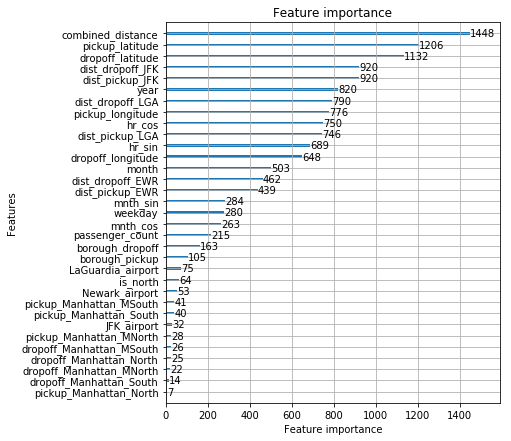

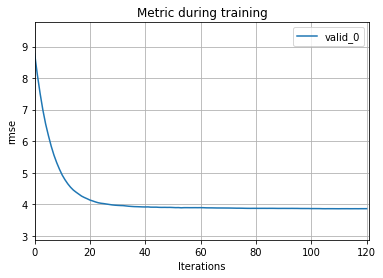

In [8]:
bst = lgb.train(params, train_data, num_round,  valid_sets=[test_data],
                evals_result=evals_result, verbose_eval=False,
               early_stopping_rounds=esr)
#Predict
pred_y_train = bst.predict(X_train)
pred_y_test = bst.predict(X_test)#, num_iteration=gbm.best_iteration)

lgb.plot_importance(bst,figsize=(6,7))
lgb.plot_metric(evals_result)

mae_train=(mean_absolute_error(y_train, pred_y_train))
mae_test=(mean_absolute_error(y_test, pred_y_test))
rmse_train=(np.sqrt(mean_squared_error(y_train, pred_y_train)))
rmse_test=(np.sqrt(mean_squared_error(y_test, pred_y_test)))
print('Train data:\nMAE: {0:.3g}, RMSE: {1:.3g}'.format(mae_train, rmse_train))
print('Test data:\nMAE: {0:.3g}, RMSE: {1:.3g}'.format(mae_test, rmse_test))

In [9]:
#Cross-validation: Note: https://stackoverflow.com/questions/49774825/python-lightgbm-cross-validation-how-to-use-lightgbm-cv-for-regression
bst_cv = lgb.cv(params, train_data, num_round, nfold=5, metrics='rmse', 
       early_stopping_rounds=esr,stratified=False)
print(min(bst_cv['rmse-mean']))

3.9808369117422537



### Random search

In [10]:
random_grid = {'max_depth': [2,4,5,6,8,10,15,20,30],
               'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095],
               'min_data_in_leaf': [1],
               'learning_rate': [0.1]
              }
random_grid

{'max_depth': [2, 4, 5, 6, 8, 10, 15, 20, 30],
 'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095],
 'min_data_in_leaf': [1],
 'learning_rate': [0.1]}

In [11]:
estimator = lgb.LGBMRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random_search = RandomizedSearchCV(estimator = estimator, param_distributions = random_grid, 
                               cv = 3, n_jobs = -1, verbose=2,
                               scoring='neg_mean_absolute_error')

# Fit the random search model
random_search.fit(X_train, y_train)

print(random_search.best_params_)
print(random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


{'num_leaves': 127, 'min_data_in_leaf': 1, 'max_depth': 30, 'learning_rate': 0.1}
-1.7234961616245728


### Grid search

In [12]:
param_grid = {'max_depth': [2,4,5,6,8,10,15,20,30],
               'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095],
               'min_data_in_leaf': [1],
               'learning_rate': [0.1]
              }
param_grid

{'max_depth': [2, 4, 5, 6, 8, 10, 15, 20, 30],
 'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095],
 'min_data_in_leaf': [1],
 'learning_rate': [0.1]}

In [13]:
estimator = lgb.LGBMRegressor()

grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,
                          scoring='neg_mean_absolute_error')
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 32.3min finished


{'learning_rate': 0.1,
 'max_depth': 30,
 'min_data_in_leaf': 1,
 'num_leaves': 255}

When performing the grid search with more data, different parameters are obtained. The final parameters in modelling.ipynb may hence be different from those given above (which are based on a training set of ~90k rows). 

### Bayesian optimization

**To be implemented**
